# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Установите количество пропущенных значений поля <code>age</code>:

In [164]:
train_data = pd.read_csv('/content/titanic_train.csv')
ages = list(train_data['age'])
count = 0
for age in ages:
  if str(age) == 'nan':
    count += 1
count


199

Определите долю выживших

In [165]:
result = list(train_data['survived'])
print(result.count(1)/len(result))

0.382262996941896


Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [166]:
train_data = train_data.drop('ticket', axis=1)
deleted = []
features = ['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'home.dest']
for feature in features:
  f = list(train_data[feature])
  count = 0
  for f1 in f:
    if str(f1) == 'nan' or str(f1) == '':
      count += 1
  if count/len(f)>0.3:
    train_data = train_data.drop(feature, axis=1)
    deleted.append(feature)
print(deleted)
train_data

['cabin', 'home.dest']


,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S
...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,8.0500,S
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,8.0500,S
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,13.0000,S
979,3,0,"Barton, Mr. David John",male,22.0,0,0,8.0500,S


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [167]:
train_data['fam_size'] = train_data['sibsp'] + train_data['parch']
train_data = train_data.drop('sibsp', axis=1)
train_data = train_data.drop('parch', axis=1)
train_data

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [168]:
print(np.mean(train_data['fam_size']))

0.8664627930682977


На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [169]:
def remove_data(df):
    del_indices = []
    for index, row in df.iterrows():
        if row['sex']!='female' or row['pclass']!=3:
            del_indices.append(index)

    return df.drop(del_indices).reset_index(drop=True)

choose = remove_data(train_data)
print(list(choose['survived']).count(1)/len(choose))

0.5030674846625767


Постройте гистограммы выжиших и невыживших по возрастам.

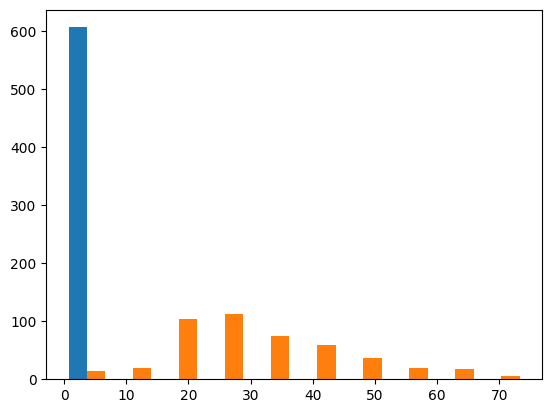

In [170]:
def remove_surv(df, surv):
    del_indices = []
    for index, row in df.iterrows():
        if row['survived']==surv:
            del_indices.append(index)

    return df.drop(del_indices).reset_index(drop=True)

choose = remove_surv(train_data,1)

import matplotlib.pyplot as plt
features = ['pclass', 'name', 'sex', 'fare', 'fam_size', 'embarked']
for feature in features:
   choose = choose.drop(feature, axis=1)
plt.hist(choose)
plt.show()
#choose

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [171]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

cat_features = ['name', 'sex', 'embarked']

for feature in cat_features:
  train_data = train_data.drop(feature, axis=1)

In [172]:
train_data_without = train_data.dropna()
y = train_data_without['survived']
train_data_without = train_data_without.drop('survived', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(train_data_without, y, test_size=0.2, random_state=41,stratify=y)

model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = f1_score(y_test, y_pred)
print("Коэффициент детерминации R^2:", r2)

Коэффициент детерминации R^2: 0.5565217391304348


## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [173]:
train_data_without = train_data.fillna(train_data.mean())
y = train_data_without['survived']
train_data_without = train_data_without.drop('survived', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(train_data_without, y, test_size=0.2, random_state=41,stratify=y)

model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = f1_score(y_test, y_pred)
print("Коэффициент детерминации R^2:", r2)

Коэффициент детерминации R^2: 0.48120300751879697


## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [174]:
train_data_help = pd.read_csv('/content/titanic_train.csv')
names = list(train_data_help['name'])
for i in range(len(names)):
  names[i] = names[i].split(',')[1]
  names[i] = names[i].split('.')[0].strip()

print(set(names))

{'Don', 'Capt', 'Mrs', 'Mlle', 'the Countess', 'Master', 'Mr', 'Rev', 'Dona', 'Miss', 'Dr', 'Ms', 'Col', 'Major'}


Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [175]:
for i in range(len(names)):
  if names[i] == 'Rev' or  names[i] == 'Col' or  names[i] == 'Dr' or  names[i] == 'Major' or  names[i] == 'Don' or  names[i] == 'Capt':
    names[i] = 'Mr'
  elif names[i] == 'Dona' or  names[i] == 'the Countess':
    names[i] = 'Mrs'
  elif names[i] == 'Mlle' or  names[i] == 'Ms':
    names[i] = 'Miss'

train_data['honorific'] = names
print(set(names))

train_data

{'Mr', 'Master', 'Miss', 'Mrs'}


,pclass,survived,age,fare,fam_size,honorific
0,3,1,NaN,7.7333,0,Miss
1,3,1,NaN,7.7500,0,Miss
2,3,1,38.0,7.2292,0,Mrs
3,3,0,22.0,7.8958,0,Mr
4,3,0,16.0,9.5000,0,Mr
...,...,...,...,...,...,...
976,3,1,NaN,8.0500,0,Miss
977,3,1,19.0,8.0500,0,Mr
978,2,0,34.0,13.0000,0,Mr
979,3,0,22.0,8.0500,0,Mr


Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [176]:
print(names.count('Master')/(names.count('Master') + names.count('Mr')))

0.07232704402515723


Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [177]:
def remove_male(df):
    del_indices = []
    for index, row in df.iterrows():
        if row['honorific']!='Mr':
            del_indices.append(index)

    return df.drop(del_indices).reset_index(drop=True)

choose = remove_male(train_data)

print(np.mean(choose['age']))

32.90043763676149


Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [178]:
Miss = 22.00576540880503
Mrs = 36.98425196850393
Master = 5.128205128205129
Mr = 32.90043763676149

ages = train_data['age']
hono = train_data['honorific']

for i in range(len(ages)):
  if str(ages[i]) == 'nan':
    if hono[i] == 'Miss':
      ages[i] = Miss
    elif hono[i] == 'Mrs':
      ages[i] = Mrs
    elif hono[i] == 'Master':
      ages[i] = Master
    elif hono[i] == 'Mr':
      ages[i] = Mr
train_data['age'] = ages

<ipython-input-178-b0e140e6508d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages[i] = Miss
<ipython-input-178-b0e140e6508d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages[i] = Miss
<ipython-input-178-b0e140e6508d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages[i] = Mr
<ipython-input-178-b0e140e6508d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

In [179]:
train_data = train_data.drop('honorific', axis = 1)
y = train_data['survived']
train_data = train_data.drop('survived', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=41,stratify=y)

model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = f1_score(y_test, y_pred)
print("Коэффициент детерминации R^2:", r2)

Коэффициент детерминации R^2: 0.48484848484848486


# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [181]:
train_data['sex'] = train_data_help['sex']
train_data['embarked'] = train_data_help['embarked']

train_data = pd.get_dummies(train_data, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, random_state=41,stratify=y)

model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = f1_score(y_test, y_pred)
print("Коэффициент детерминации R^2:", r2)

Коэффициент детерминации R^2: 0.676056338028169


In [184]:
test_data = pd.read_csv('/content/titanic_reserved.csv')
names = list(test_data['name'])
for i in range(len(names)):
  names[i] = names[i].split(',')[1]
  names[i] = names[i].split('.')[0].strip()

print(set(names))

{'Mrs', 'Sir', 'Master', 'Mr', 'Rev', 'Lady', 'Mme', 'Miss', 'Dr', 'Col', 'Major', 'Jonkheer'}


In [185]:
for i in range(len(names)):
  if names[i] == 'Rev' or  names[i] == 'Col' or  names[i] == 'Dr' or  names[i] == 'Major' or  names[i] == 'Don' or  names[i] == 'Capt':
    names[i] = 'Mr'
  elif names[i] == 'Dona' or  names[i] == 'the Countess':
    names[i] = 'Mrs'
  elif names[i] == 'Mlle' or  names[i] == 'Ms':
    names[i] = 'Miss'

test_data['honorific'] = names
print(set(names))

test_data

{'Mrs', 'Sir', 'Master', 'Mr', 'Lady', 'Mme', 'Miss', 'Jonkheer'}


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,honorific
0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN,Mr
1,1,"Snyder, Mr. John Pillsbury",male,24.0000,1,0,21228,82.2667,B45,S,"Minneapolis, MN",Mr
2,2,"Ashby, Mr. John",male,57.0000,0,0,244346,13.0000,NaN,S,"West Hoboken, NJ",Mr
3,3,"Rosblom, Mr. Viktor Richard",male,18.0000,1,1,370129,20.2125,NaN,S,NaN,Mr
4,2,"Doling, Miss. Elsie",female,18.0000,0,1,231919,23.0000,NaN,S,Southampton,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...
323,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,"Philadelphia, PA",Mr
324,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0000,0,0,111428,26.5500,NaN,S,"New York, NY",Mr
325,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C,"New York, NY",Mrs
326,2,"Caldwell, Master. Alden Gates",male,0.8333,0,2,248738,29.0000,NaN,S,"Bangkok, Thailand / Roseville, IL",Master


In [189]:
def remove_male(df):
    del_indices = []
    for index, row in df.iterrows():
        if row['honorific']!='Master':
            del_indices.append(index)

    return df.drop(del_indices).reset_index(drop=True)

choose = remove_male(test_data)

print(np.mean(choose['age']))

6.470235714285714


In [190]:
Miss = 21.290124074074075
Mrs = 36.977777777777774
Master = 6.470235714285714
Mr = 32.38775510204081

ages = test_data['age']
hono = test_data['honorific']

for i in range(len(ages)):
  if str(ages[i]) == 'nan':
    if hono[i] == 'Miss':
      ages[i] = Miss
    elif hono[i] == 'Mrs':
      ages[i] = Mrs
    elif hono[i] == 'Master':
      ages[i] = Master
    elif hono[i] == 'Mr':
      ages[i] = Mr
test_data['age'] = ages

test_data

<ipython-input-190-39d6cc03f87a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages[i] = Mr
<ipython-input-190-39d6cc03f87a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages[i] = Mrs
<ipython-input-190-39d6cc03f87a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages[i] = Master
<ipython-input-190-39d6cc03f87a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,honorific
0,3,"Sage, Mr. Frederick",male,32.387755,8,2,CA. 2343,69.5500,NaN,S,NaN,Mr
1,1,"Snyder, Mr. John Pillsbury",male,24.000000,1,0,21228,82.2667,B45,S,"Minneapolis, MN",Mr
2,2,"Ashby, Mr. John",male,57.000000,0,0,244346,13.0000,NaN,S,"West Hoboken, NJ",Mr
3,3,"Rosblom, Mr. Viktor Richard",male,18.000000,1,1,370129,20.2125,NaN,S,NaN,Mr
4,2,"Doling, Miss. Elsie",female,18.000000,0,1,231919,23.0000,NaN,S,Southampton,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...
323,1,"Brewe, Dr. Arthur Jackson",male,32.387755,0,0,112379,39.6000,NaN,C,"Philadelphia, PA",Mr
324,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.000000,0,0,111428,26.5500,NaN,S,"New York, NY",Mr
325,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,36.977778,1,0,PC 17604,82.1708,NaN,C,"New York, NY",Mrs
326,2,"Caldwell, Master. Alden Gates",male,0.833300,0,2,248738,29.0000,NaN,S,"Bangkok, Thailand / Roseville, IL",Master


In [191]:
test_data = test_data.drop('name', axis=1)
test_data = test_data.drop('honorific', axis=1)
test_data = test_data.drop('home.dest', axis=1)
test_data = test_data.drop('cabin', axis=1)
test_data = test_data.drop('ticket', axis=1)

test_data

,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,32.387755,8,2,69.5500,S
1,1,male,24.000000,1,0,82.2667,S
2,2,male,57.000000,0,0,13.0000,S
3,3,male,18.000000,1,1,20.2125,S
4,2,female,18.000000,0,1,23.0000,S
...,...,...,...,...,...,...,...
323,1,male,32.387755,0,0,39.6000,C
324,1,male,45.000000,0,0,26.5500,S
325,1,female,36.977778,1,0,82.1708,C
326,2,male,0.833300,0,2,29.0000,S


In [192]:
test_data['fam_size'] = test_data['sibsp'] + test_data['parch']
test_data = test_data.drop('sibsp', axis=1)
test_data = test_data.drop('parch', axis=1)
test_data

,pclass,sex,age,fare,embarked,fam_size
0,3,male,32.387755,69.5500,S,10
1,1,male,24.000000,82.2667,S,1
2,2,male,57.000000,13.0000,S,0
3,3,male,18.000000,20.2125,S,2
4,2,female,18.000000,23.0000,S,1
...,...,...,...,...,...,...
323,1,male,32.387755,39.6000,C,0
324,1,male,45.000000,26.5500,S,0
325,1,female,36.977778,82.1708,C,1
326,2,male,0.833300,29.0000,S,2


In [193]:
train_data

,pclass,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,22.005765,7.7333,0,False,True,False
1,3,22.005765,7.7500,0,False,True,False
2,3,38.000000,7.2292,0,False,False,False
3,3,22.000000,7.8958,0,True,False,True
4,3,16.000000,9.5000,0,True,False,True
...,...,...,...,...,...,...,...
976,3,22.005765,8.0500,0,False,False,True
977,3,19.000000,8.0500,0,True,False,True
978,2,34.000000,13.0000,0,True,False,True
979,3,22.000000,8.0500,0,True,False,True


In [194]:
test_data = pd.get_dummies(test_data, drop_first=True)

In [195]:
test_data

,pclass,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,32.387755,69.5500,10,True,False,True
1,1,24.000000,82.2667,1,True,False,True
2,2,57.000000,13.0000,0,True,False,True
3,3,18.000000,20.2125,2,True,False,True
4,2,18.000000,23.0000,1,False,False,True
...,...,...,...,...,...,...,...
323,1,32.387755,39.6000,0,True,False,False
324,1,45.000000,26.5500,0,True,False,True
325,1,36.977778,82.1708,1,False,False,False
326,2,0.833300,29.0000,2,True,False,True


In [199]:
res = '['
predict = list(model.predict(test_data))

for i in range(len(predict)):
  res += str(predict[i]) + ', '

res += ']'

print(res)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ]
